# 대규모 데이터 학습

In [1]:
# 피처의 종류가 많을 때는 일부만 선택하고 나머진 안 써도 된다
# 개수가 많은 것은 그렇지 않다. 데이터는 많으면 많을수록 테스트 퍼포먼스가 높아질 가능성이 높아진다
# 그래서 여기에서는 셀렉션을 쓰지 않는다. 쓰긴 다 써야 한다
# 대용량의 데이터를 소화할 수 있는 모델과 할 수 없는 모델로 분류가 된다
# 소화할 수 있는 모델만 사용해야 한다
# 할 수 없는 모델의 예가 서포트벡터머신
# 소화할 수 있는 가장 대표적인 모델은 퍼셉트론, 정확하게는 SGD
    # Misclassified 된 상태의 데이터에서 일부만 선택해 gradeint 벡터를 업데이트 하는 데 쓴다
    # 데이터를 처음부터 쪼개서 일부만 집어넣으면 된다. 대신에 다음번엔 또 다른 데이터를 집어넣여야 함

대규모 데이터(big data)의 경우에는 메모리 등의 문제로 특정한 모형은 사용할 수 없는 경우가 많다. 이 때는 

* 사전 확률분포를 설정할 수 있는 생성 모형
* 시작 가중치를 설정할 수 있는 모형

등을 이용하고 전체 데이터를 처리 가능한 작은 조각으로 나누어 학습을 시키는 점진적 학습 방법을 사용한다. 

여기에서는 대용량 데이터의 예로 대표 수종 데이터를 이용한다.

In [1]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

covtype = fetch_covtype(shuffle=True, random_state=0)
X_covtype = covtype.data
y_covtype = covtype.target - 1
classes = np.unique(y_covtype)
X_train, X_test, y_train, y_test = train_test_split(X_covtype, y_covtype, shuffle=True, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

학습 데이터의 개수는 400,000개 이상이다.

In [2]:
X_train.shape

(435759, 54)

In [2]:
# 실제로 현업에서는 많은 데이터는 아님
# 두 가지 경우가 있을 수 있다
    # 하나는 메모리에 한 번에 올릴 수 없는 경우
    # 하나는 올리긴 올렸는데 모델에 넣어서 돌리니까 안 끝나는 경우
# 그럴 땐 데이터 쪼개서 조금만 넣는 것

이 데이터를 메모리에 한번에 올릴 수 없다고 가정하고 다음처럼 일부 데이터만 로드하는 함수를 만든다.

In [3]:
def read_Xy(start, end):
    # 실무에서는 파일이나 데이터베이스에서 읽어온다.
    idx = list(range(start, min(len(y_train) - 1, end)))
    X = X_train[idx, :]
    y = y_train[idx]
    return X, y

In [20]:
# 여기선 메모리에서 끊어오는 건데 현실에서는 아예 파일에서 읽을 때 조금만 읽거나
# 데이터베이스에서 쿼리를 줄 때 where이나 constraint를 줘서 조금만 가져오는 방식을 사용

## SGD

우선 SGD 모형에 대해 전체 데이터를 이용하여 구한 성능을 살펴보자.

In [4]:
%%time
from sklearn.linear_model import SGDClassifier

model = SGDClassifier().fit(X_train, y_train)

CPU times: user 7.33 s, sys: 70 ms, total: 7.4 s
Wall time: 7.15 s


In [5]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69    158936
           1       0.73      0.80      0.77    212431
           2       0.60      0.88      0.72     26746
           3       0.58      0.15      0.23      2065
           4       0.34      0.04      0.07      7115
           5       0.47      0.02      0.04     13055
           6       0.69      0.50      0.58     15411

    accuracy                           0.71    435759
   macro avg       0.59      0.44      0.44    435759
weighted avg       0.70      0.71      0.69    435759



In [6]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69     52904
           1       0.73      0.81      0.77     70870
           2       0.61      0.88      0.72      9008
           3       0.61      0.14      0.23       682
           4       0.33      0.04      0.07      2378
           5       0.53      0.03      0.05      4312
           6       0.68      0.50      0.58      5099

    accuracy                           0.71    145253
   macro avg       0.60      0.44      0.44    145253
weighted avg       0.70      0.71      0.70    145253



전체 데이터를 한번에 사용하였을 경우 학습 성능과 검증 성능이 모두 71의 정확도를 보인다.

SGD 모형은 가중치를 계속 업데이트하므로 일부 데이터를 사용하여 구한 가중치를 다음 단계에서 초기 가중치로 사용할 수 있다. 
이렇게 하려면 모형을 생성할 때 `warm_start` 인수를 True로 하고 `partial_fit` 메서드로 학습을 시킨다.

In [4]:
# SGD를 쓰게 되면 얘는 가중치를 갖다가 계속 업데이트하기 때문에 데이터를 쪼개서 조금씩 넣어줘도 된다
# 그런데 다 넣어준 다음에는 다시 처음으로 돌아가서 다시 차례로 집어넣으면서 업데이트 반복
# 이렇게 데이터를 한 번 다 사용하는 것을 영어로 epoch(에포크)라고 한다. 한 세기(시기)

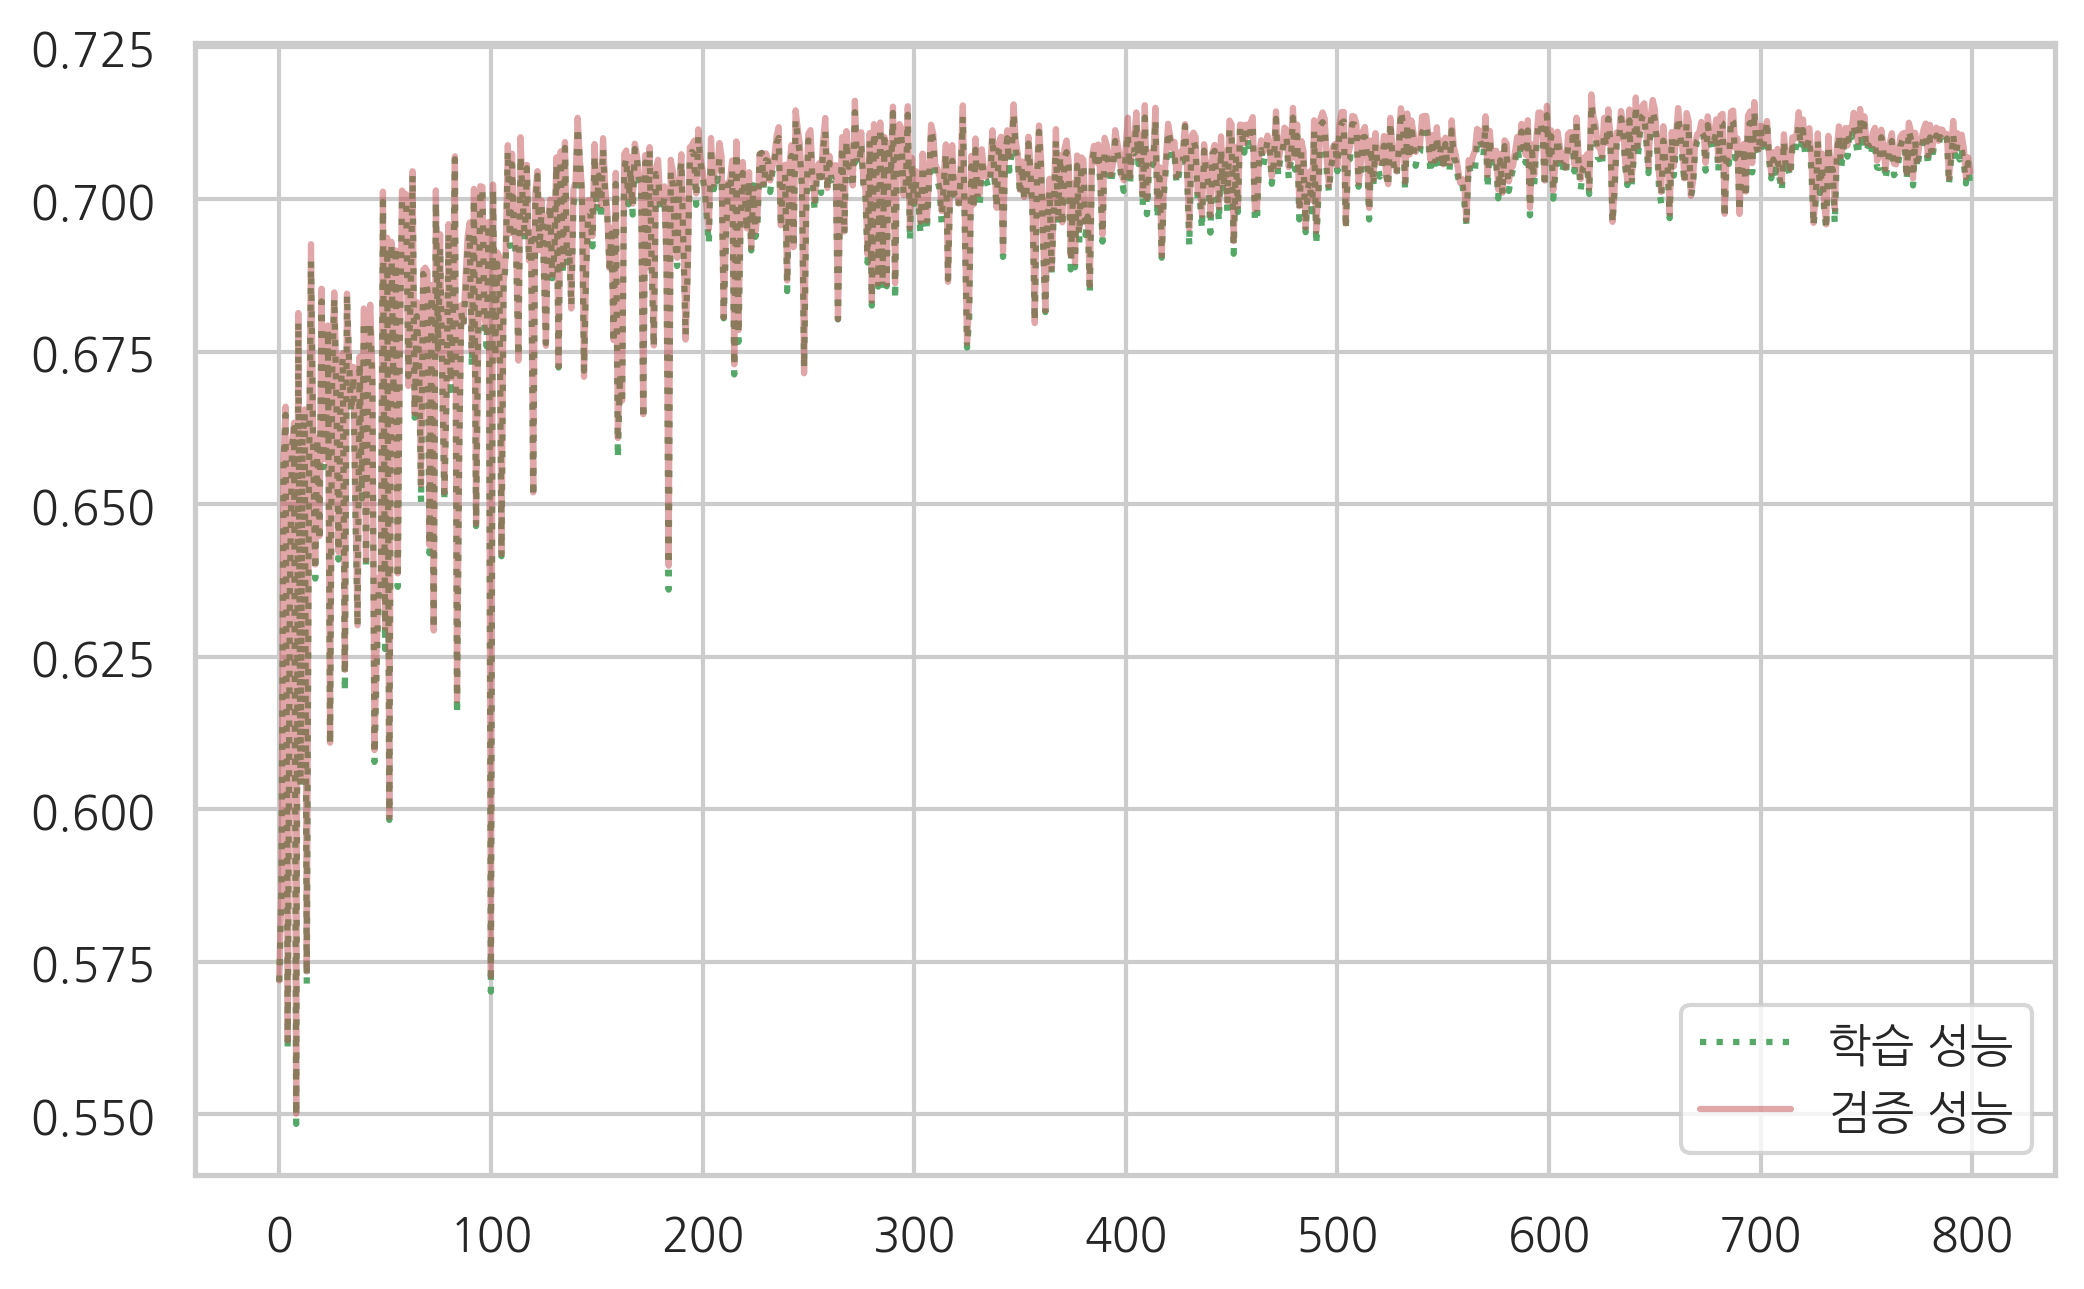

CPU times: user 3min 45s, sys: 7.89 s, total: 3min 53s
Wall time: 59.1 s


In [7]:
%%time

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

model = SGDClassifier(warm_start=True)

# 데이터를 400개의 조각으로 나누어 읽는다.
n_split = 400
n_X = len(y_train) // n_split
n_epoch = 2 # number of epoch
accuracy_train = []
accuracy_test = []
for epoch in range(n_epoch):
    for n in range(n_split):
        X, y = read_Xy(n * n_X, (n + 1) * n_X)
        model.partial_fit(X, y, classes=classes)
        accuracy_train.append(accuracy_score(y_train, model.predict(X_train)))
        accuracy_test.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(accuracy_train, "g:", label="학습 성능")
plt.plot(accuracy_test, "r-", alpha=0.5, label="검증 성능")
plt.legend()
plt.show()

In [19]:
# warm start 값을 true로 주면 fit 이라는 명령 대신에 partial_fit을 쓰게 된다.
    # warm start는 피팅할 때 처음에 이미 만들어진 것은 안 건드린다. 추가한 애만 피팅시킨다 
# 이걸 할 때마다 기존에 있는 값을 지우지 않고 옛날 값에서 한 번 돌아갈 때마다 업데이트를 하게 된다.
# 기존에 하던 순서 따라 최적화하던 것을 쪼개서 간다고 생각하면 된다

## 베르누이 나이브베이즈 모형

In [7]:
# 또 다른 대규모 데이터를 처리할 수 있는 모형
# 처음에는 확률이 높지 않지만 데이터가 쌓일 수록 점점 더 성능이 향상된다

대표 수종 데이터 중 X11부터는 0과 1로 이루어진 데이터이므로 베르누이 나이브 베이즈 모형을 사용할 수 있다.

In [8]:
%%time

from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB().fit(X_train[:, 10:], y_train)

CPU times: user 770 ms, sys: 50 ms, total: 820 ms
Wall time: 338 ms


In [9]:
y_train_pred = model.predict(X_train[:, 10:])
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54    158936
           1       0.65      0.78      0.71    212431
           2       0.59      0.87      0.71     26746
           3       0.45      0.59      0.51      2065
           4       0.23      0.06      0.10      7115
           5       0.24      0.21      0.22     13055
           6       0.62      0.58      0.60     15411

    accuracy                           0.63    435759
   macro avg       0.49      0.51      0.48    435759
weighted avg       0.63      0.63      0.62    435759



In [10]:
y_test_pred = model.predict(X_test[:, 10:])
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54     52904
           1       0.65      0.78      0.71     70870
           2       0.60      0.87      0.71      9008
           3       0.43      0.56      0.49       682
           4       0.23      0.06      0.10      2378
           5       0.23      0.20      0.21      4312
           6       0.62      0.57      0.59      5099

    accuracy                           0.63    145253
   macro avg       0.49      0.50      0.48    145253
weighted avg       0.63      0.63      0.62    145253



나이브베이즈 모형과 같은 생성모형은 일부 데이터를 이용하여 구한 클래스 사전확률이나 가능도 확률분포모수를 추정할 때 데이터를 부분적으로 받아서 업데이트를 하는 `partial_fit` 메서드를 지원한다.

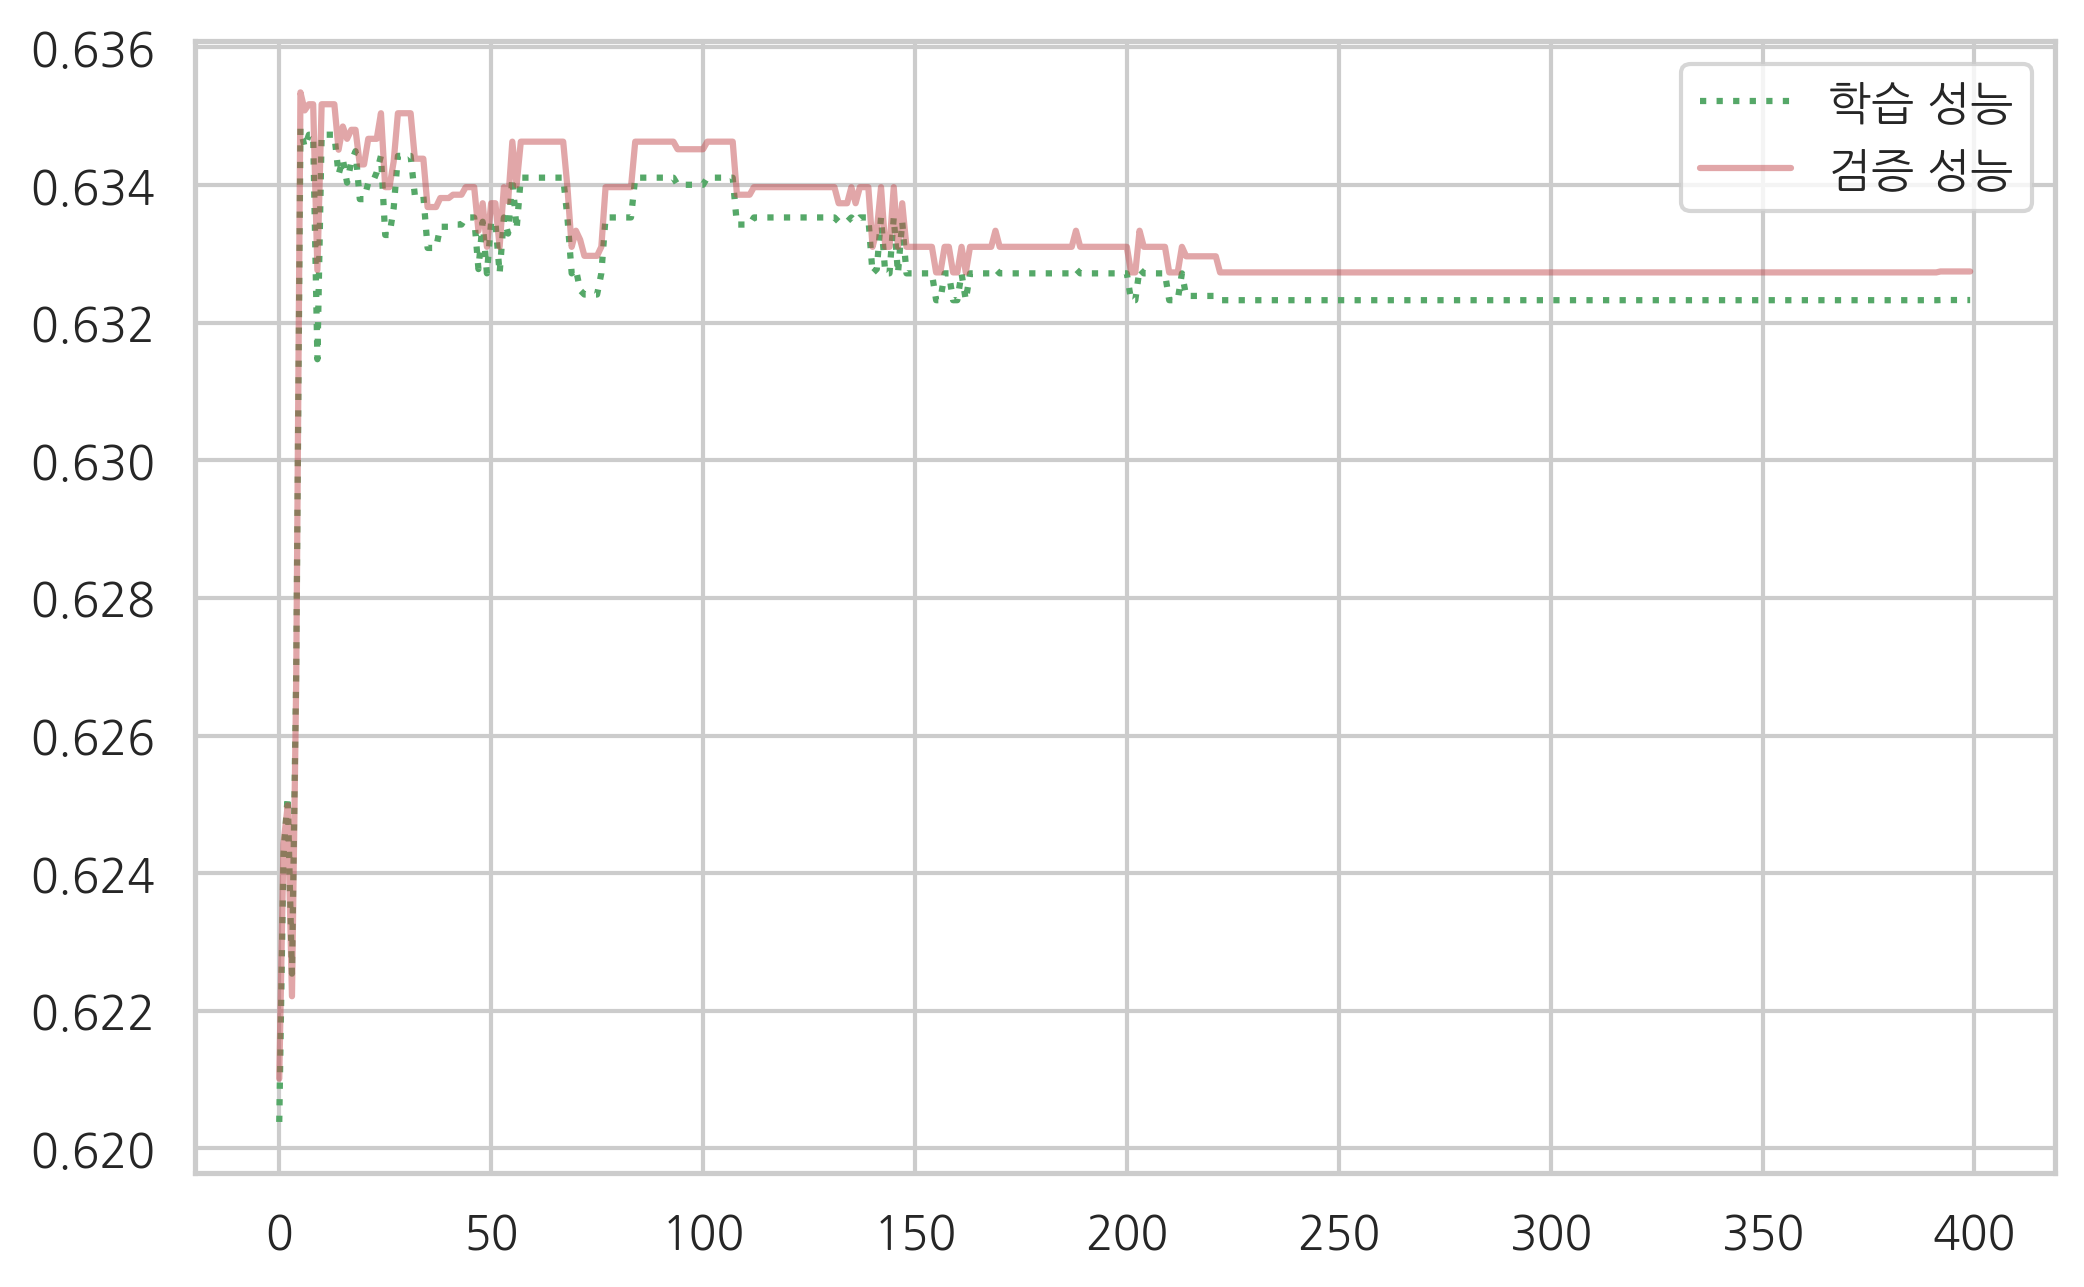

CPU times: user 7min 25s, sys: 19.7 s, total: 7min 45s
Wall time: 2min 8s


In [11]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_split = 400
n_X = len(y_train) // n_split

model = BernoulliNB(alpha=0)

accuracy_train = []
accuracy_test = []
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.partial_fit(X[:, 10:], y, classes=classes)
    accuracy_train.append(accuracy_score(y_train, model.predict(X_train[:, 10:])))
    accuracy_test.append(accuracy_score(y_test, model.predict(X_test[:, 10:])))

plt.plot(accuracy_train, "g:", label="학습 성능")
plt.plot(accuracy_test, "r-", alpha=0.5, label="검증 성능")
plt.legend()
plt.show()

In [9]:
# 맨 처음에는 퍼포먼스가 낫게 나오다가 금방 성능이 올라오는 것을 볼 수 있다

In [10]:
# 여기까지가 정상적으로 데이터를 다 써서 할 수 있는 방법

## Random Forest

In [11]:
# 랜덤포레스트는 정상적으로 데이터를 쪼개서 할 수 없지만 tricky하게 약간 기형적으로 사용하는 방식이 있다

In [12]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train, y_train)

CPU times: user 15.6 s, sys: 200 ms, total: 15.8 s
Wall time: 10.4 s


In [13]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158936
           1       1.00      1.00      1.00    212431
           2       1.00      1.00      1.00     26746
           3       1.00      0.99      0.99      2065
           4       1.00      0.98      0.99      7115
           5       1.00      0.99      1.00     13055
           6       1.00      1.00      1.00     15411

    accuracy                           1.00    435759
   macro avg       1.00      0.99      1.00    435759
weighted avg       1.00      1.00      1.00    435759



In [14]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     52904
           1       0.95      0.95      0.95     70870
           2       0.92      0.95      0.94      9008
           3       0.92      0.80      0.86       682
           4       0.92      0.72      0.81      2378
           5       0.92      0.85      0.88      4312
           6       0.97      0.92      0.95      5099

    accuracy                           0.94    145253
   macro avg       0.93      0.88      0.90    145253
weighted avg       0.94      0.94      0.94    145253



랜덤 포레스트와 같은 앙상블 모형에서는 일부 데이터를 사용한 모형을 개별 분류기로 사용할 수 있다.

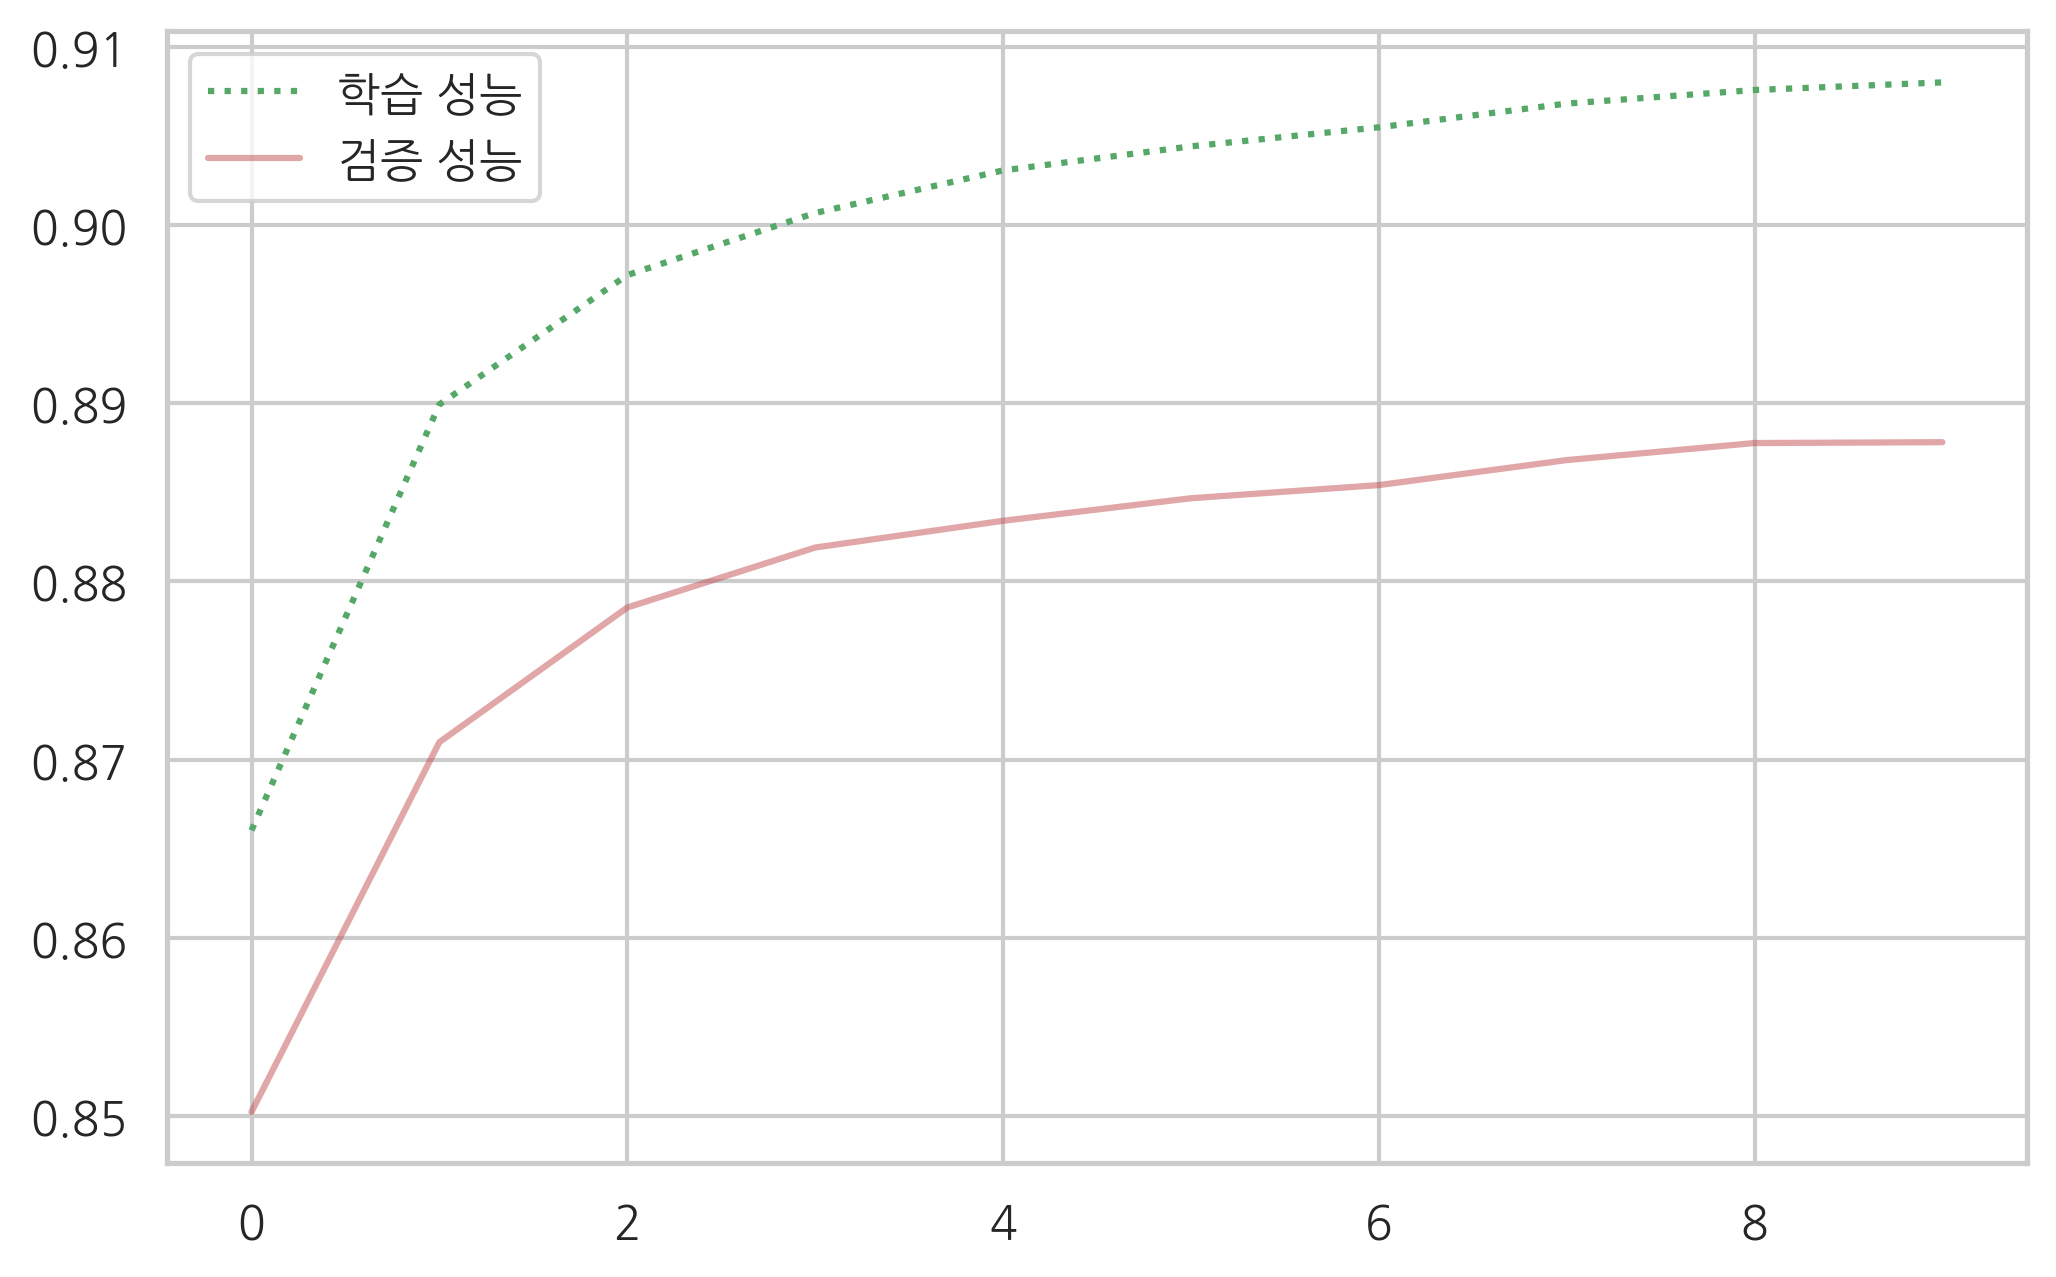

CPU times: user 4min 1s, sys: 6.57 s, total: 4min 8s
Wall time: 1min 7s


In [15]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n_split = 10
n_X = len(y_train) // n_split
num_tree_ini = 10
num_tree_step = 10

model = RandomForestClassifier(n_estimators=num_tree_ini, warm_start=True)

accuracy_train = []
accuracy_test = []
for n in range(n_split):
    X, y = read_Xy(n * n_X, (n + 1) * n_X)
    model.fit(X, y)
    accuracy_train.append(accuracy_score(y_train, model.predict(X_train)))
    accuracy_test.append(accuracy_score(y_test, model.predict(X_test)))
    model.n_estimators += num_tree_step

plt.plot(accuracy_train, "g:", label="학습 성능")
plt.plot(accuracy_test, "r-", alpha=0.5, label="검증 성능")
plt.legend()
plt.show()

In [16]:
# 첫 번째 데이터를 푸는 랜덤 포레스트(10개의 디시전 트리), 두 번째 데이터를 푸는 랜덤포레스트(10개의 디시전 트리)
# 엄격하게 말하면 원래 문제(전체 데이터)를 푸는 게 아니다. 하나는 첫 번째 데이터를, 다른 하나는 두 번째 데이터를 풀고 있는 것
# 숲을 데이터별로 쪼개는 것. 배깅을 한 것과 거의 비슷한 효과가 난다
# 강제로 데이터를 쪼개서 하는 것이다 보니 성능이 많이 나오진 않는다

In [18]:
# 이 방법은 그레디언트 부스팅과 에이다 부스팅에도 똑같이 적용할 수 있다

## 그레디언트 부스팅

그레디언트 부스팅에서도 유사하게 초기 커미티 멤버로 일부 데이터를 사용하여 학습한 모형을 사용할 수 있다.